In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import uniform as sp_rand
from scipy.stats import randint


pd.set_option('display.max_columns', 300)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(palette="Dark2")

In [2]:
all_outliers = {}
results = {}
best_regressors = {}

In [3]:
"""Calculate RMSE"""
# def rmse(Y, Y_pred, apply_log=False):

#     if apply_log:
#         Z = np.log(Y) - np.log(Y_pred)
#     else:
#         Z = Y - Y_pred

#     return -np.sqrt(np.sum(Z**2)/len(Z))

def rmse(Y, Y_pred):
    Z = Y - Y_pred
    return -np.sqrt(np.sum(Z**2)/len(Z))

def log_rmse(Y, Y_pred):
    Z = np.log(Y) - np.log(Y_pred)
    return -np.sqrt(np.sum(Z**2)/len(Z))

rmse_scorer = make_scorer(rmse)
log_rmse_scorer = make_scorer(log_rmse)


In [4]:
def print_scores_ridge(GS, scorer, X, Y, Bayesian=False):
    if Bayesian:
        print("Best Parms : ", GS.best_params_)    
    else:
        print("Best alpha : ", GS.best_estimator_.alpha)
        
    print("Best R2 Score within CV : ", GS.best_score_)
    print("Best R2 Score on unseen test data", GS.best_estimator_.score(X, Y)) 
    print("Best RMSE Score on unseen test data", scorer(GS.best_estimator_.predict(X),Y))
    
    if(not Bayesian):
        x = GS.cv_results_["mean_test_rmse"]
        min = np.where(x == x.max())
        x_intercept  = GS.cv_results_["param_alpha"][min][0]
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        plt.title("Alpha vs RMSE")
        _ = sns.lineplot(x = GS.cv_results_["param_alpha"], y =  GS.cv_results_["mean_test_rmse"])
        _ = plt.axvline(GS.cv_results_["param_alpha"][min][0], color="purple")

        x = GS.cv_results_["mean_test_R2"]
        max = np.where(x == x.max())
        x_intercept  = GS.cv_results_["param_alpha"][max][0]
        plt.subplot(1,2,2)
        plt.title("Alpha vs R2")
        _ = sns.lineplot(x = GS.cv_results_["param_alpha"], y =  GS.cv_results_["mean_test_R2"])
        _ = plt.axvline(GS.cv_results_["param_alpha"][max][0], color="orange")
        _ = plt.axvline(GS.cv_results_["param_alpha"][min][0], color="purple")
        plt.show()



In [5]:
def get_top_and_bottom_coef(coef, train):
    coef_pd = pd.Series(coef, index = train.columns)
    imp_coef = pd.concat([coef_pd.sort_values().head(10),coef_pd.sort_values().tail(10)])
#     abs_coef = coef_pd.abs().sort_values()
    least_coef = coef_pd.abs().sort_values().head(20)
    
    plt.rcParams['figure.figsize'] = (16.0, 8.0)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.subplot(1,2,1)
    plt.title("Least important Coefficients")
    least_coef.plot(kind = "barh")
    plt.subplot(1,2,2)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.title("Most important Coefficients")
    imp_coef.plot(kind = "barh")
    plt.show()
    return (imp_coef, least_coef)

In [6]:
def print_scores_forest(GS, scorer, X, Y, Forest=True):
    rgsr = GS.best_estimator_
    print("Best parms : ", GS.best_params_)
    print("Best regressor : \n", rgsr)

    if(Forest):
        print("OOB Score  : ", rgsr.oob_score_)
    else:
        print("Best R2 score :",rgsr.score(X,Y))
    Y_pred = rgsr.predict(X)
    print("Best RMSE Score on unseen test data:", scorer(Y_pred,Y))
        
    temp = pd.DataFrame({"Prediction":Y_pred, "Actual": Y})
    _ = sns.lmplot(x = "Actual", y =  "Prediction",data = temp, height=8)
    plt.show()

In [7]:
def get_top_and_bottom_features(GS,train):
    rgsr = GS.best_estimator_
#     feature_import = pd.DataFrame(data=regressor.feature_importances_, index=X_scaled.columns.values, columns=['values'])
# feature_import.sort_values(['values'], ascending=False, inplace=True)
# feature_import.transpose()

    coef_pd = pd.Series(rgsr.feature_importances_, index = train.columns).sort_values(ascending=False)
    imp_coef = coef_pd.head(20)
    least_coef = coef_pd.abs().tail(20)
    
    plt.rcParams['figure.figsize'] = (16.0, 8.0)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.subplot(1,2,1)
    plt.title("Least important Coefficients")
    least_coef.plot(kind = "barh")
    plt.subplot(1,2,2)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.title("Most important Coefficients")
    imp_coef.plot(kind = "barh")
    plt.show()
    return (imp_coef, least_coef)

In [8]:
def get_outliers(Y_pred, Y, plot_fig = True):
    resid = Y - Y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    Z = (resid - mean_resid)/std_resid
    outliers = np.where(abs(Z) > abs(Z).std() * 3)[0]
    
    
    if(plot_fig):
        plt.figure(figsize=(8, 6))
        plt.scatter(Y, Y_pred, alpha=0.2)
        plt.scatter(Y[outliers], Y_pred[outliers])
        plt.show()
    
    return outliers

# Set 3
Ordinal : No <br>
Standardized : Yes

In [9]:
set_num = "set2_"

def create_submission_file(set_str, filename, test_X, pred_Y, log_transform=False):
    sub_data = test_X.copy()
    if log_transform:
        pred_Y = np.exp(pred_Y)
    sub_data["SalePrice"] = pred_Y
    
    sub_data = sub_data[["SalePrice"]]
    
    file = "../data/submission/" + set_str + filename +".csv"
    sub_data.to_csv(file)
        


In [10]:
train_data = pd.read_csv("../data/processed_data/train_processed_set2.csv",index_col=0)
submission_data = pd.read_csv("../data/processed_data/test_processed_set2.csv",index_col=0)

print(train_data.shape)
print(submission_data.shape)

X = train_data.drop("SalePrice", axis=1)
Y2 = np.log(train_data["SalePrice"])
Y = train_data["SalePrice"]



train_X, test_X, train_Y, test_Y = train_test_split(X, Y,test_size=0.2, random_state=99)
# train_X, test_X, train_Y, test_Y = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1:],test_size=0.2, random_state=99)

train_X2, test_X2, train_Y2, test_Y2 = train_test_split(X, Y2,test_size=0.2, random_state=99)



print("\n")
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

print("\n")
print(train_X2.shape)
print(train_Y2.shape)
print(test_X2.shape)
print(test_Y2.shape)


(1460, 238)
(1459, 237)


(1168, 237)
(1168,)
(292, 237)
(292,)


(1168, 237)
(1168,)
(292, 237)
(292,)


In [11]:
train_data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,SalePrice,Age,AgeRemod,TotalArea,TotalSF,TotalFullBaths,TotalHalfBaths,TotalPorch,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_1,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_1,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_1,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_None,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolArea_Yes,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Remod_True
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [12]:
train_X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,Age,AgeRemod,TotalArea,TotalSF,TotalFullBaths,TotalHalfBaths,TotalPorch,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_1,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_1,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_1,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_None,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolArea_Yes,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Remod_True
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [13]:
train_Y.head()

Id
543     213250
1407    133000
339     202500
18       90000
1314    333168
Name: SalePrice, dtype: int64

In [14]:
train_Y2.head()

Id
543     12.270220
1407    11.798104
339     12.218495
18      11.407565
1314    12.716402
Name: SalePrice, dtype: float64

# Ridge with Y

In [100]:
estimator = Ridge(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e3,500)}
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.01 s, sys: 121 ms, total: 2.14 s
Wall time: 10.1 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, random_state=55, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-02, 2.01399e+00, ..., 9.97996e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  50.10969939879759
Best R2 Score within CV :  -0.15882533268116011
Best R2 Score on unseen test data 0.9007659678024632
Best RMSE Score on unseen test data -0.12865046839461872


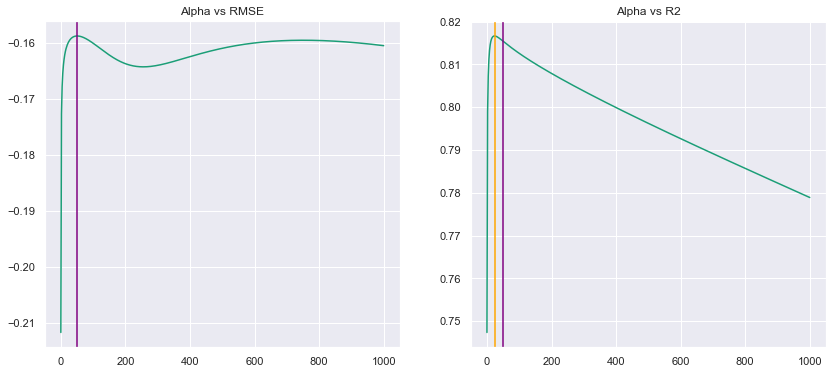

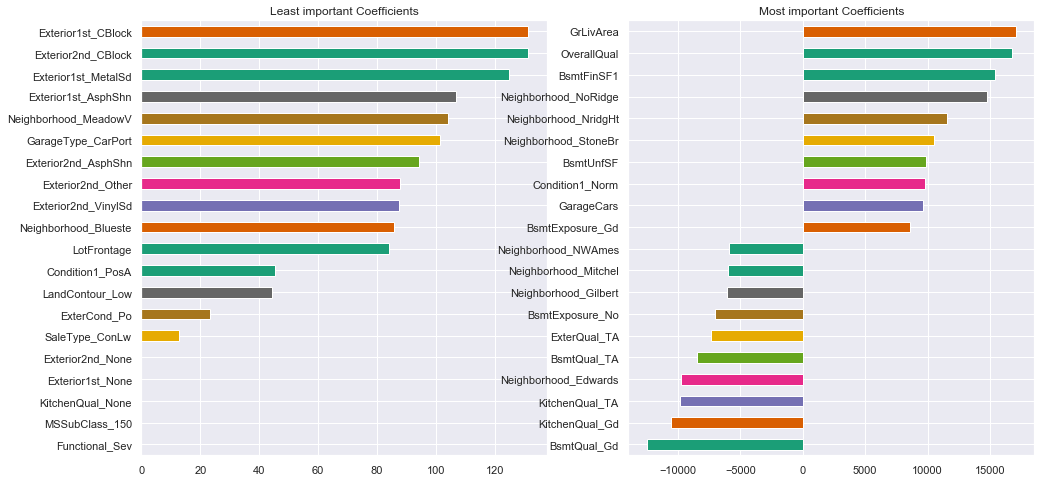

In [101]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


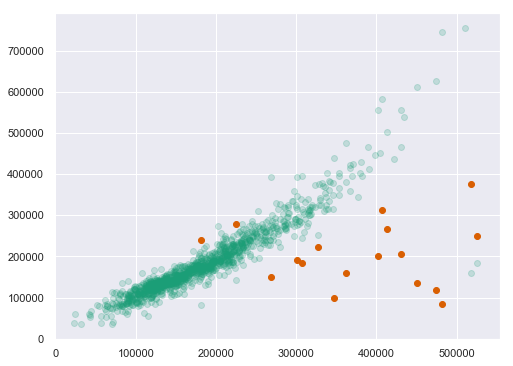

In [102]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["Ridge"] = outliers

In [103]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Ridge"] = pred_Y
best_regressors["Ridge"] = grid_search.best_estimator_
create_submission_file(set_num, "Ridge", submission_data, pred_Y, log_transform=False)

# Ridge with log(Y)

In [105]:
# estimator = Ridge(random_state=55, max_iter=2000)
# cvs = 5
# param_grid = [
#     {'alpha': np.linspace(1e-2,1e3,500)}
# ]

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 2.27 s, sys: 142 ms, total: 2.42 s
Wall time: 10.5 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, random_state=55, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-02, 2.01399e+00, ..., 9.97996e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  22.05386773547094
Best R2 Score within CV :  -0.1423513807331538
Best R2 Score on unseen test data 0.9094990774330522
Best RMSE Score on unseen test data -0.1082486943179727


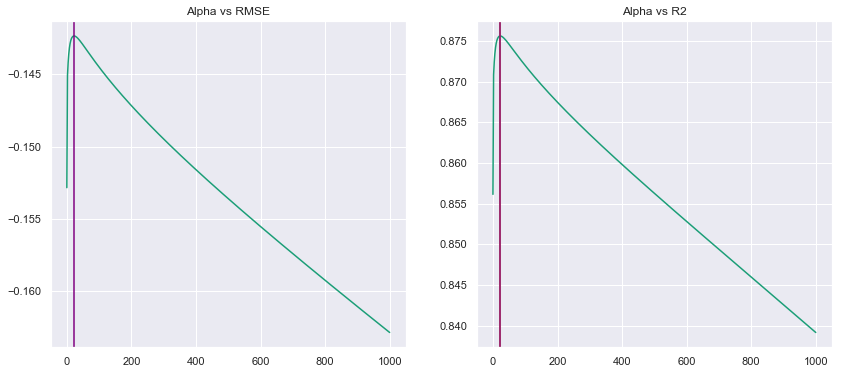

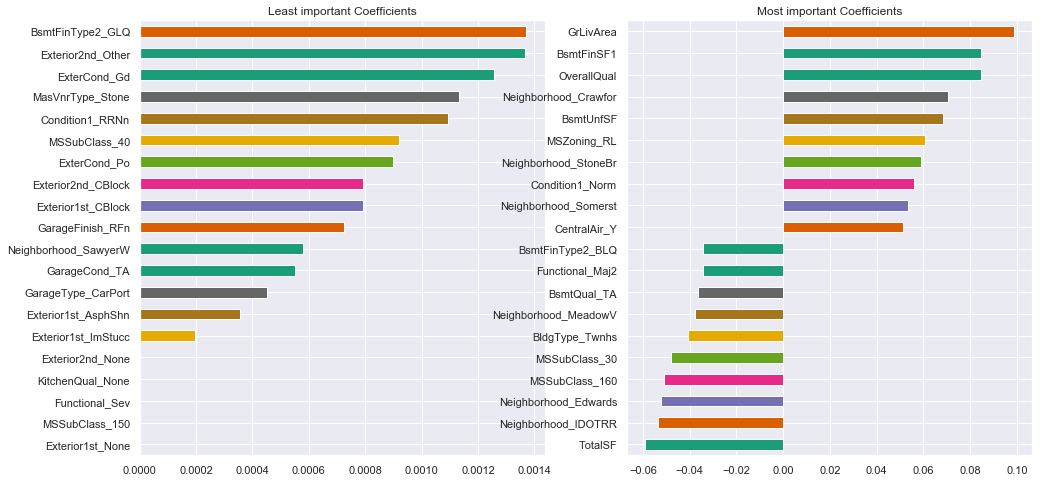

In [106]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


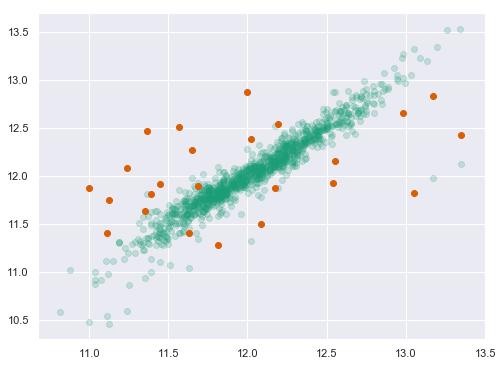

In [107]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["Ridge_Log"] = outliers

In [110]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Ridge_Log"] = np.exp(pred_Y)
best_regressors["Ridge_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "Ridge_Log", submission_data, pred_Y, log_transform=True)

# Lasso with Y

In [111]:
estimator = Lasso(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e3,500)}
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 7.32 s, sys: 572 ms, total: 7.89 s
Wall time: 54.9 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=55,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-02, 2.01399e+00, ..., 9.97996e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  170.3489779559118
Best R2 Score within CV :  -0.15541150717597396
Best R2 Score on unseen test data 0.9048810323623577
Best RMSE Score on unseen test data -0.12548733588551644


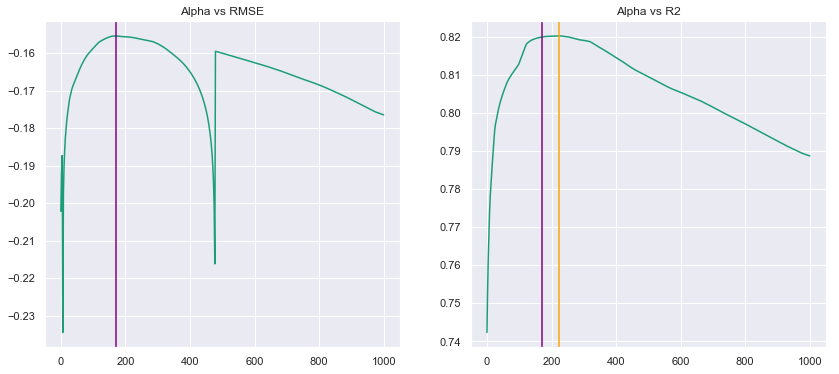

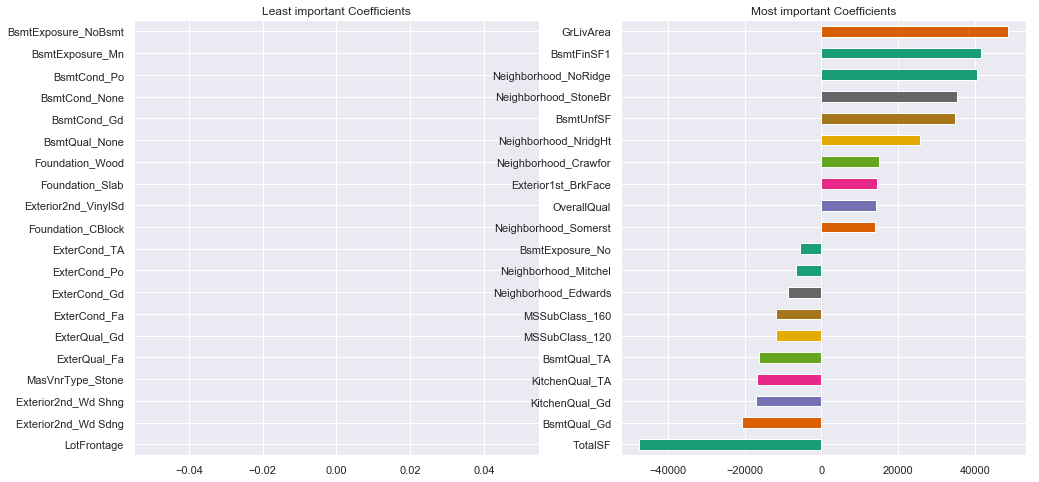

In [112]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


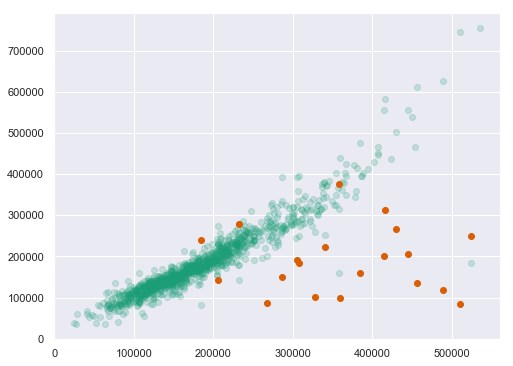

In [113]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["Lasso"] = outliers

In [114]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Lasso"] = pred_Y
best_regressors["Lasso"] = grid_search.best_estimator_
create_submission_file(set_num, "Lasso", submission_data, pred_Y, log_transform=False)

# Lasso with log(Y)

In [115]:
estimator = Lasso(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-4,1e2,200)}
]

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 937 ms, sys: 41.8 ms, total: 979 ms
Wall time: 4.05 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=55,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-04, 5.02612e-01, ..., 9.94975e+01, 1.00000e+02])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.0001
Best R2 Score within CV :  -0.14520006723271928
Best R2 Score on unseen test data 0.896830927411849
Best RMSE Score on unseen test data -0.11557686941541256


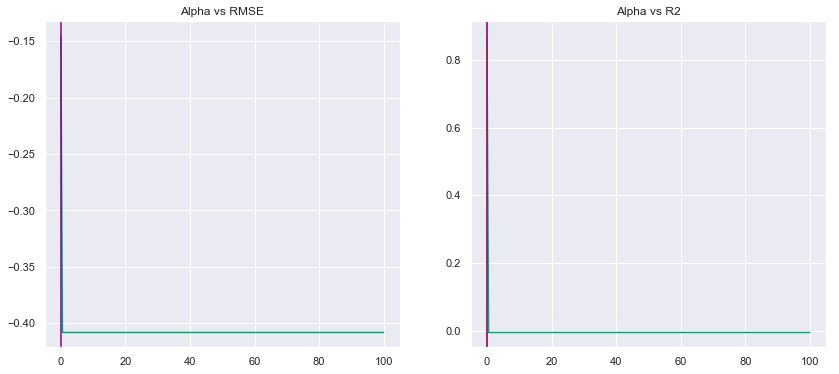

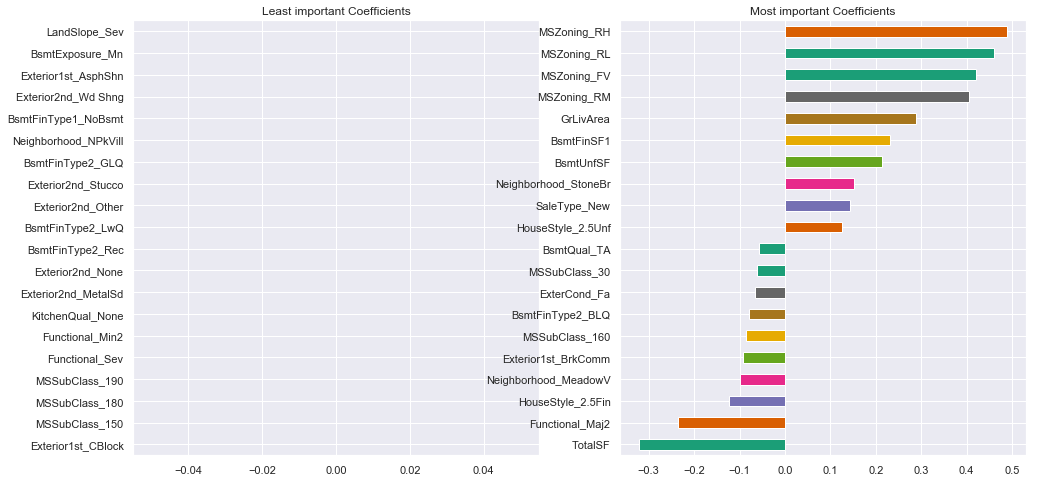

In [116]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


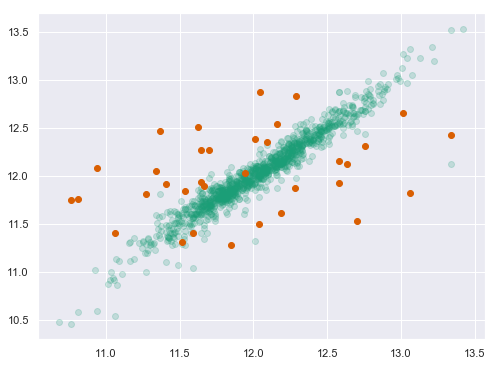

In [117]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["Lasso_Log"] = outliers

In [118]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Lasso_Log"] = np.exp(pred_Y)
best_regressors["Lasso_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "Lasso_log", submission_data, pred_Y, log_transform=True)

# ElasticNet with Y

In [35]:
estimator = ElasticNet(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e1,20),
     "l1_ratio" : np.linspace(0,1,10)
    }
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.56 s, sys: 174 ms, total: 2.73 s
Wall time: 41.3 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([ 0.01   ,  0.53579,  1.06158,  1.58737,  2.11316,  2.63895,
        3.16474,  3.69053,  4.21632,  4.74211,  5.26789,  5.79368,
        6.31947,  6.84526,  7.37105,  7.89684,  8.42263,  8.94842,
        9.47421, 10.     ]), 'l1_ratio': array([0.     , 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667,
       0.77778, 0.88889, 1.     ])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.5357894736842106
Best R2 Score within CV :  -0.15884164540110565
Best R2 Score on unseen test data 0.8993328879186112
Best RMSE Score on unseen test data -0.12923407142898727


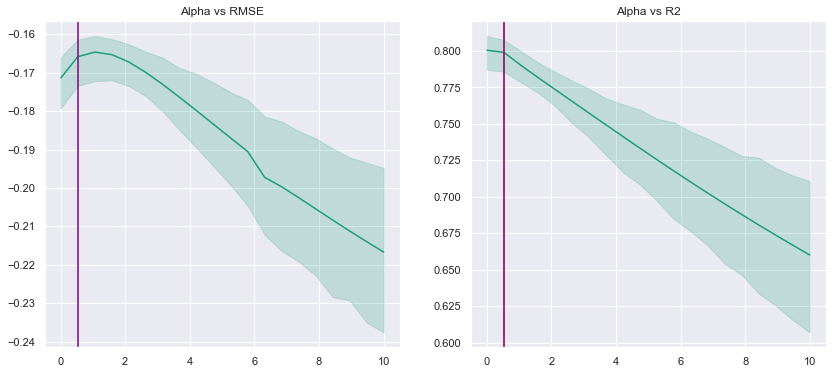

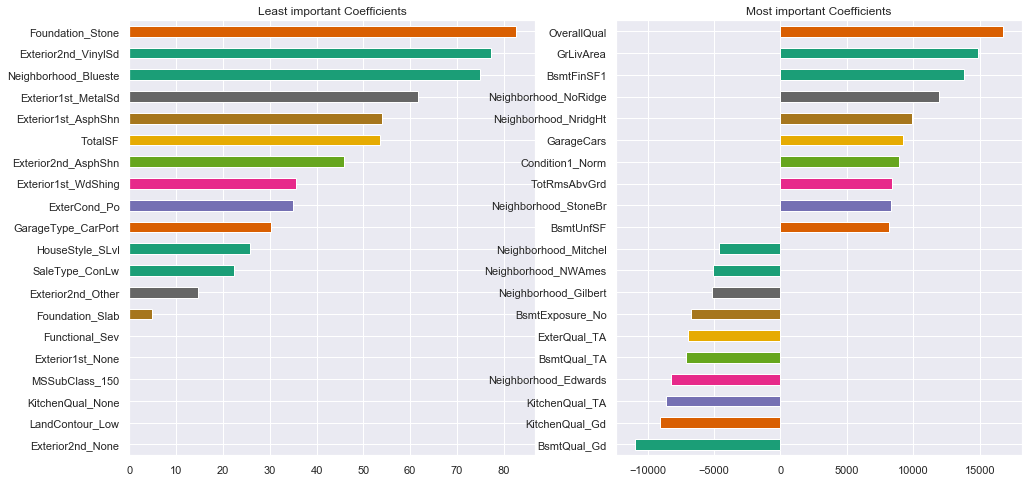

In [36]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


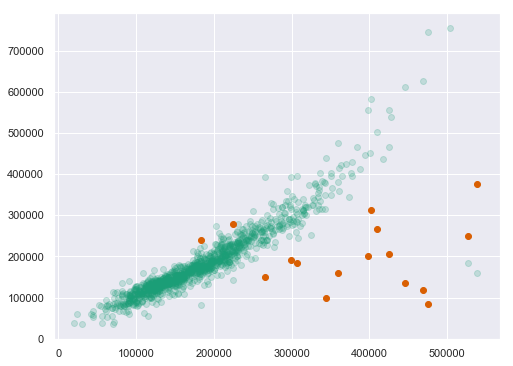

In [37]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["ENet"] = outliers

In [38]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet"] = pred_Y
best_regressors["ENet"] = grid_search.best_estimator_
create_submission_file(set_num, "ENet", submission_data, pred_Y, log_transform=False)

# ElasticNet with Y - Using RandomizedSearchCV for faster search

In [39]:
estimator = ElasticNet(random_state=55, max_iter=2000)
cvs = 5
param_grid = {
    'alpha': np.linspace(1e-4,1e-2,200),
    "l1_ratio" : sp_rand()
    }

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_distributions=param_grid ,cv=cvs, scoring=custom_scoring, n_iter=50,n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 1.79 s, sys: 123 ms, total: 1.91 s
Wall time: 37.4 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha': array([0.0001 , 0.00015, ..., 0.00995, 0.01   ]), 'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a218e8d30>},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.009751256281407035
Best R2 Score within CV :  -0.16364408048338203
Best R2 Score on unseen test data 0.9021240844311145
Best RMSE Score on unseen test data -0.1280193581467404


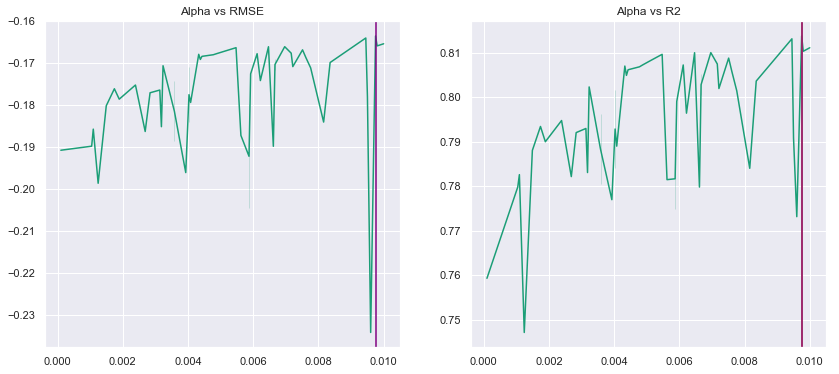

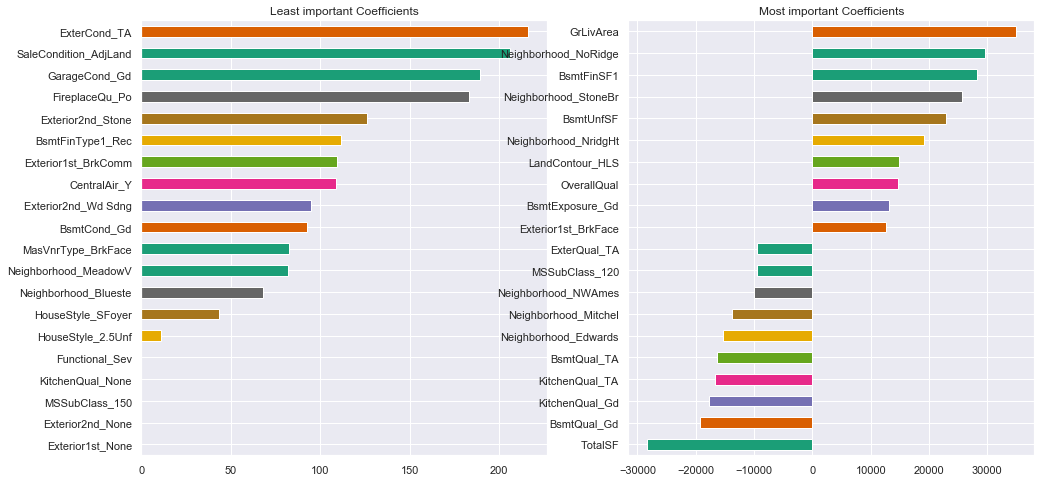

In [40]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [41]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet2"] = pred_Y
best_regressors["ENet2"] = grid_search.best_estimator_
create_submission_file(set_num, "ENet2", submission_data, pred_Y, log_transform=False)

# ElasticNet with log(Y)

In [42]:
estimator = ElasticNet(random_state=55, max_iter=3000)
cvs = 5

param_grid = [
    {'alpha': np.linspace(1e-4,1e-2,20),
     "l1_ratio" : np.linspace(0,1,10)
    }
]

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 3.28 s, sys: 207 ms, total: 3.49 s
Wall time: 43 s


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([0.0001 , 0.00062, 0.00114, 0.00166, 0.00218, 0.00271, 0.00323,
       0.00375, 0.00427, 0.00479, 0.00531, 0.00583, 0.00635, 0.00687,
       0.00739, 0.00792, 0.00844, 0.00896, 0.00948, 0.01   ]), 'l1_ratio': array([0.     , 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667,
       0.77778, 0.88889, 1.     ])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.01
Best R2 Score within CV :  -0.14297270420746994
Best R2 Score on unseen test data 0.9085408754988712
Best RMSE Score on unseen test data -0.10882024098164382


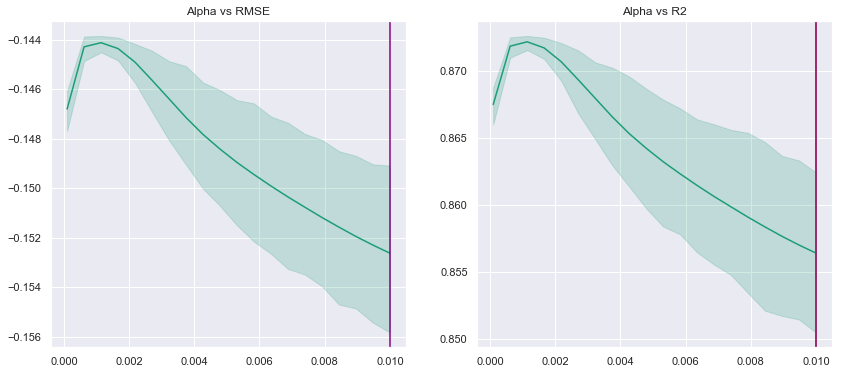

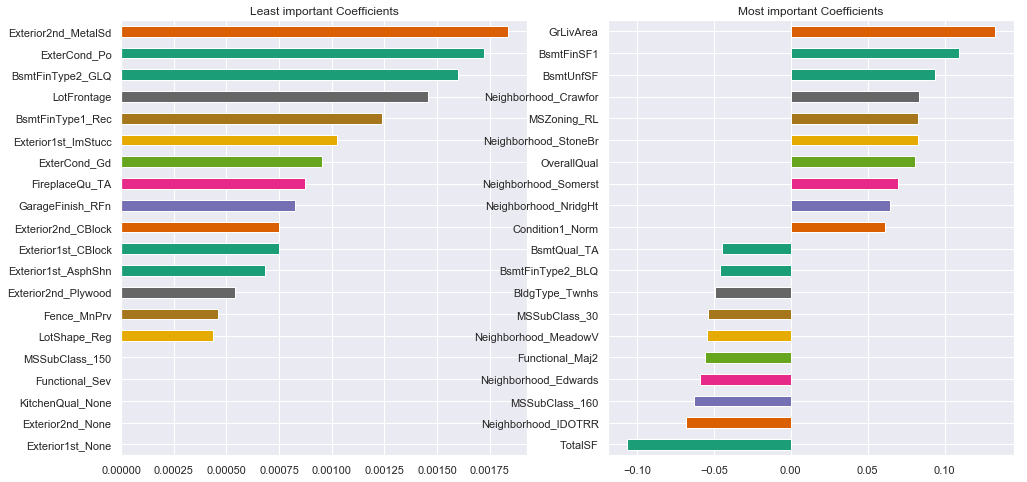

In [43]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X2)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


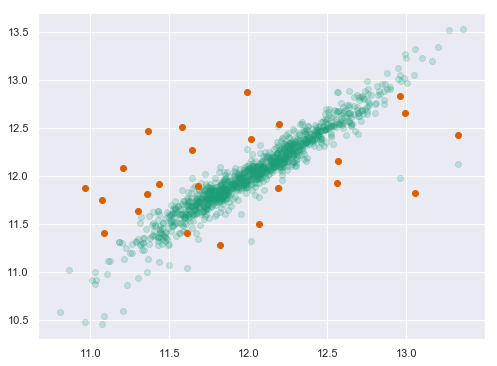

In [44]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["ENet_Log"] = outliers

In [45]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet_Log"] = np.exp(pred_Y)
best_regressors["ENet_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "ENet_Log", submission_data, pred_Y, log_transform=True)

# ElasticNet with log(Y) - Using RandomizedSearchCV for faster search

In [46]:
estimator = ElasticNet(random_state=55, max_iter=3000)
cvs = 5

param_grid = {
    'alpha': np.linspace(1e-4,1e-2,200),
    "l1_ratio" : np.linspace(0,1,100)
    }


custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid ,cv=cvs,n_iter=100, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 1.35 s, sys: 80.8 ms, total: 1.43 s
Wall time: 10.7 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'alpha': array([0.0001 , 0.00015, ..., 0.00995, 0.01   ]), 'l1_ratio': array([0.    , 0.0101, ..., 0.9899, 1.    ])},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.009253768844221105
Best R2 Score within CV :  -0.14306877618956312
Best R2 Score on unseen test data 0.9119700188738021
Best RMSE Score on unseen test data -0.10676071355412264


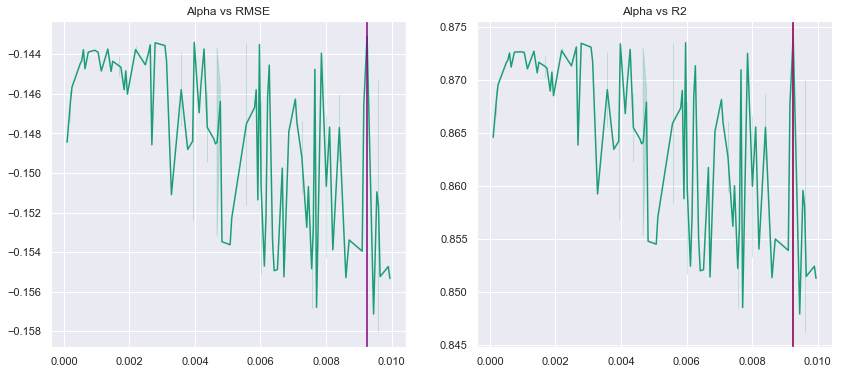

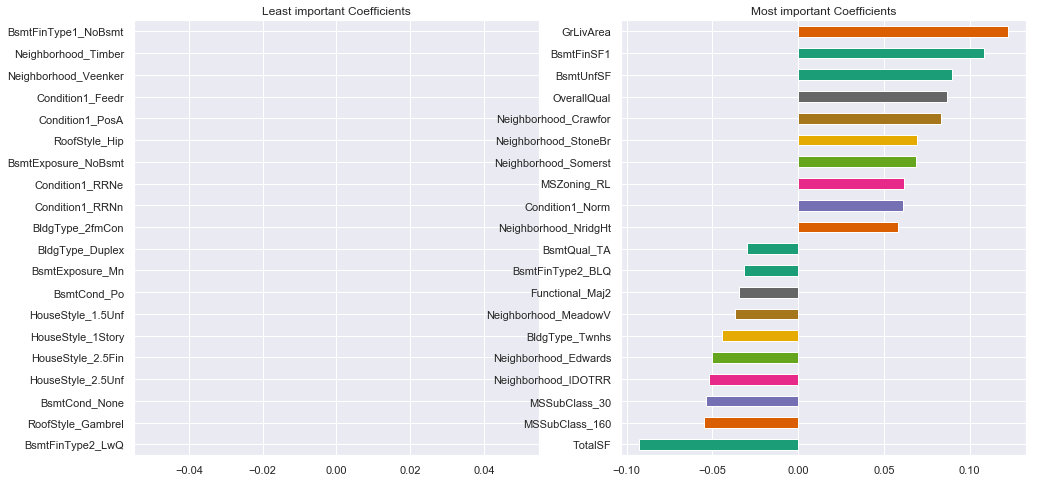

In [47]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


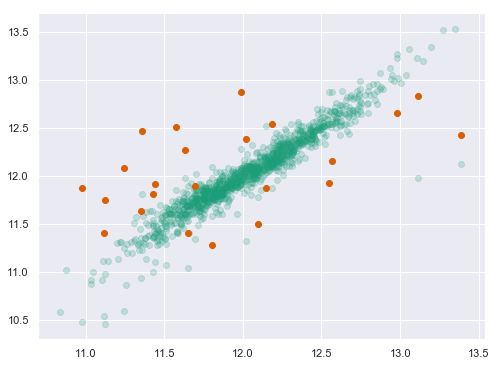

In [48]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["ENet_Log2"] = outliers

In [49]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet_Log2"] = np.exp(pred_Y)
best_regressors["ENet_Log2"] = grid_search.best_estimator_
create_submission_file(set_num, "ENet_Log2", submission_data, pred_Y, log_transform=True)

# Bayesian Ridge with Y

In [50]:
estimator = BayesianRidge()

param_grid = {
    "alpha_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "alpha_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],

}
custom_scoring = {"rmse" : "neg_mean_squared_error", "R2": "r2"}

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=50, scoring=custom_scoring, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 604 ms, sys: 43.9 ms, total: 648 ms
Wall time: 5.15 s


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'alpha_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': 'neg_mean_squared_error', 'R2': 'r2'},
          verbose=0)

Best Parms :  {'lambda_2': 100.0, 'lambda_1': 0.1, 'alpha_2': 0.01, 'alpha_1': 0.01}
Best R2 Score within CV :  -1226759577.1994982
Best R2 Score on unseen test data 0.9011933673817797
Best RMSE Score on unseen test data -0.12894217731313376


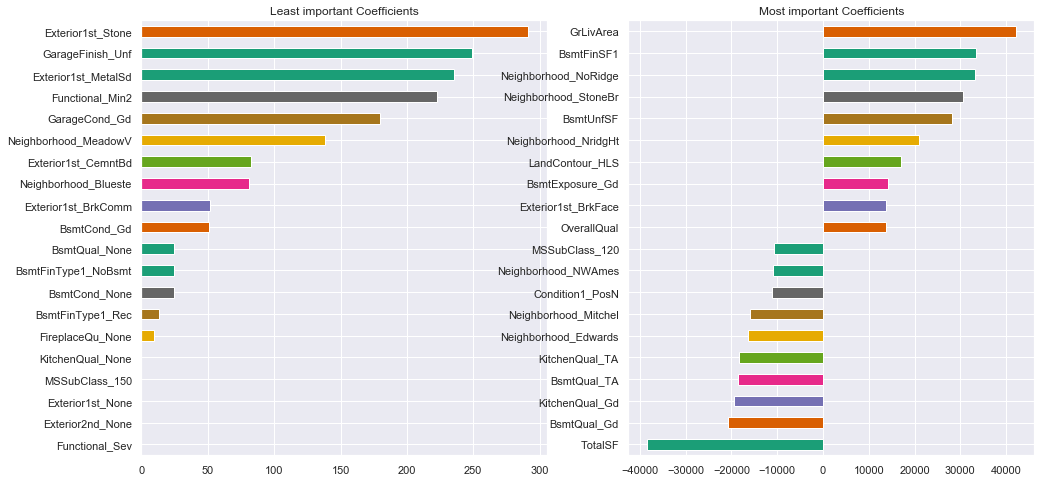

In [51]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y, Bayesian=True)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


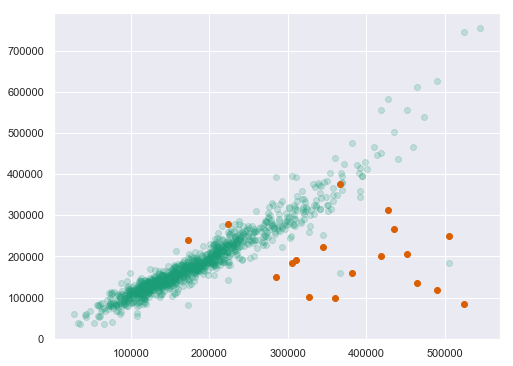

In [52]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["BayRidge"] = outliers

In [53]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["BayRidge"] = pred_Y
best_regressors["BayRidge"] = grid_search.best_estimator_
create_submission_file(set_num, "BayRidge", submission_data, pred_Y, log_transform=False)

# Bayesian Ridge with log(Y)

In [54]:
estimator = BayesianRidge()

param_grid = {
    "alpha_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "alpha_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],

}
custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=50, scoring=custom_scoring, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 652 ms, sys: 39.7 ms, total: 691 ms
Wall time: 4.21 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'alpha_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best Parms :  {'lambda_2': 0.001, 'lambda_1': 1e-05, 'alpha_2': 10.0, 'alpha_1': 100.0}
Best R2 Score within CV :  -0.142550034688683
Best R2 Score on unseen test data 0.9095977697848646
Best RMSE Score on unseen test data -0.10818965496190369


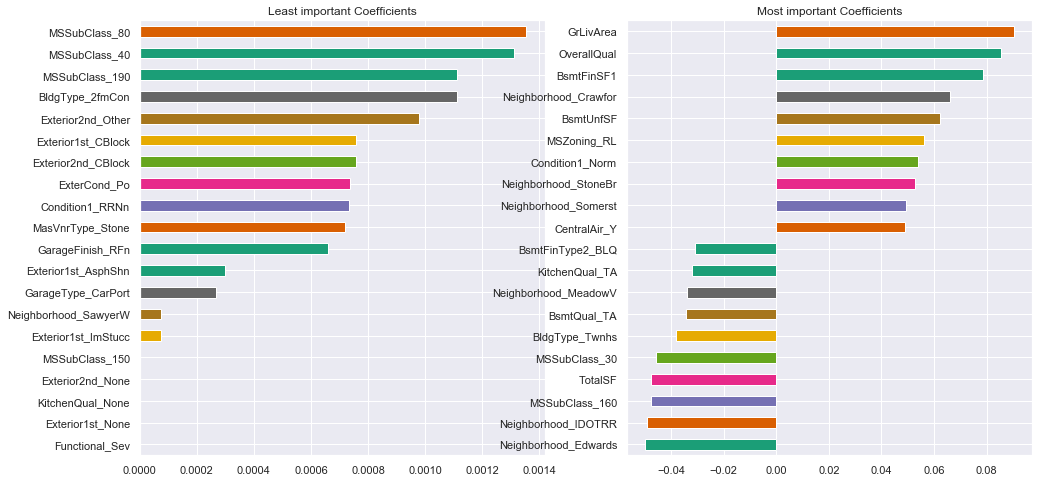

In [55]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2, Bayesian=True)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


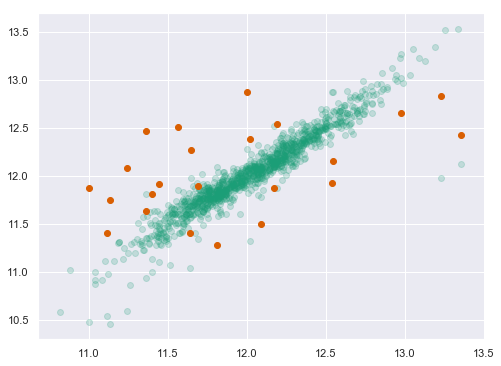

In [56]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["BayRidge_Log"] = outliers

In [57]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["BayRidge_Log"] = np.exp(pred_Y)
best_regressors["BayRidge_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "BayRidge_Log", submission_data, pred_Y, log_transform=True)

# Randomforest with Y 

In [58]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto", "sqrt", "log2", 0.2, 0.4,0.6,0.8]
    }

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100)
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.5 s, sys: 200 ms, total: 2.7 s
Wall time: 1min 3s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1d686710>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21e804e0>, 'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Best parms :  {'max_depth': 30, 'max_features': 0.6, 'n_estimators': 48}
Best regressor : 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=48, n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8489436235812327
Best RMSE Score on unseen test data: -0.11327774972375741


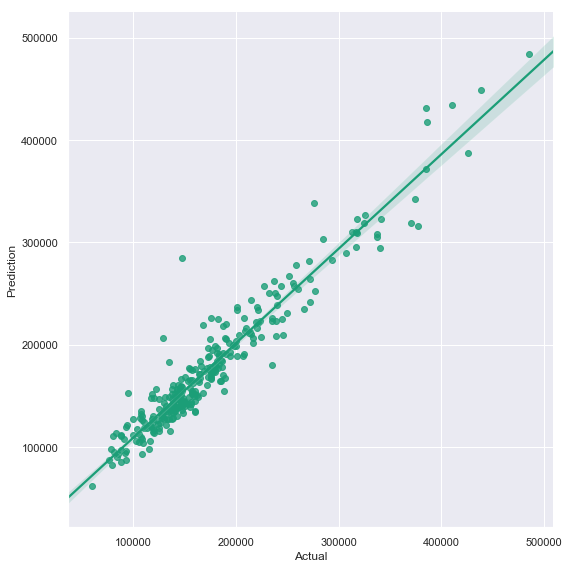

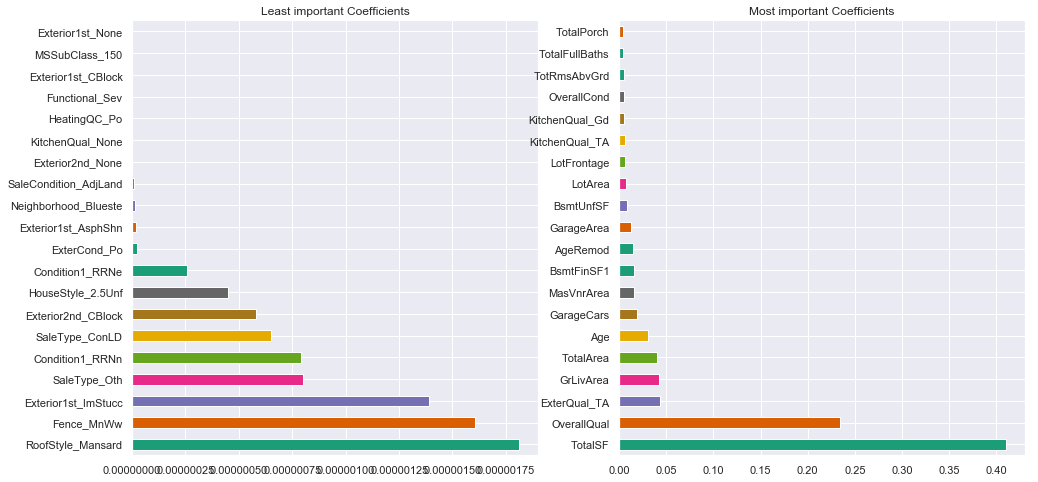

In [59]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


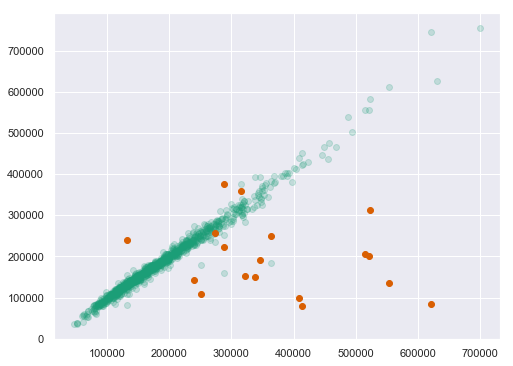

In [60]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["RF"] = outliers

In [61]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["RF"] = pred_Y
best_regressors["RF"] = grid_search.best_estimator_
create_submission_file(set_num, "RF", submission_data, pred_Y)

# Randomforest with Y - Using Grid Search to override MSE with Log RMSE

In [62]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto",]
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,  cv=5, n_iter=100,scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 4 s, sys: 202 ms, total: 4.2 s
Wall time: 2min 16s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e368b00>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e36cba8>, 'max_features': ['auto']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(log_rmse),
          verbose=0)

Best parms :  {'max_depth': 19, 'max_features': 'auto', 'n_estimators': 93}
Best regressor : 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=93, n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8378552526486606
Best RMSE Score on unseen test data: -0.1130511972090015


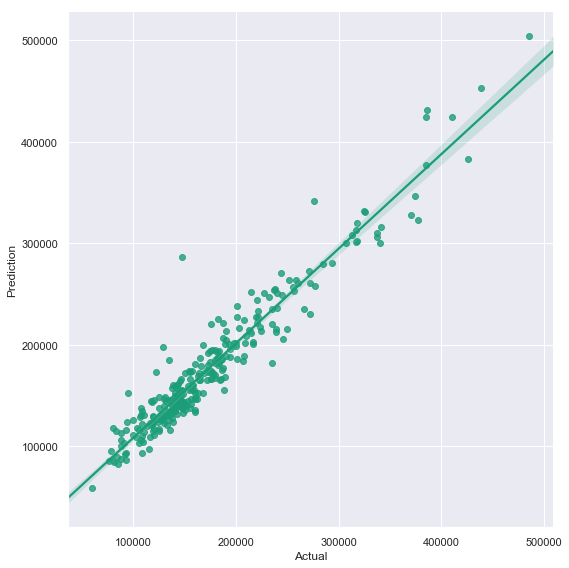

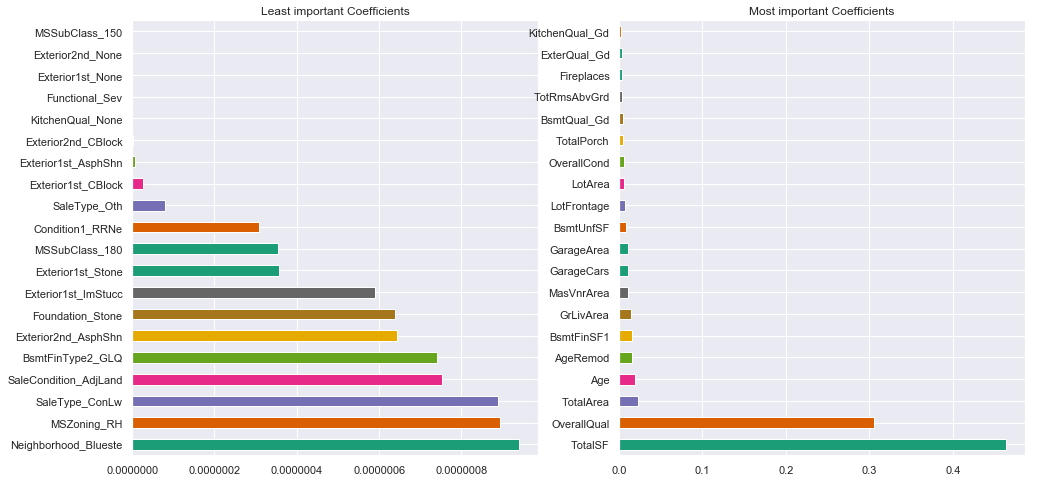

In [63]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


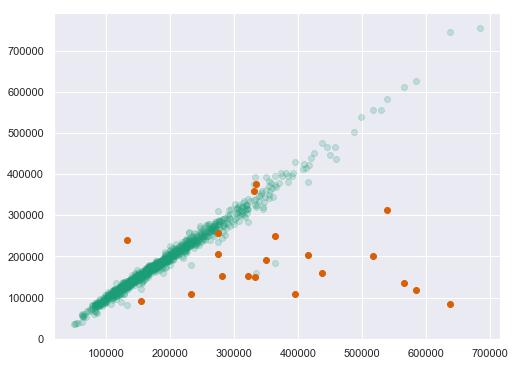

In [64]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["RF2"] = outliers

In [65]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["RF2"] = pred_Y
best_regressors["RF2"] = grid_search.best_estimator_
create_submission_file(set_num, "RF2", submission_data, pred_Y, log_transform=True)

# Randomforest with log(Y) - Using Grid Search to override MSE with Log RMSE

In [66]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto", "sqrt", "log2", 0.2, 0.4,0.6,0.8]
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,  cv=5, n_iter=100,scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 3.03 s, sys: 201 ms, total: 3.23 s
Wall time: 1min 6s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21ff6c50>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21ff6438>, 'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

Best parms :  {'max_depth': 18, 'max_features': 0.2, 'n_estimators': 96}
Best regressor : 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8730089108991317
Best RMSE Score on unseen test data: -0.11089600674630273


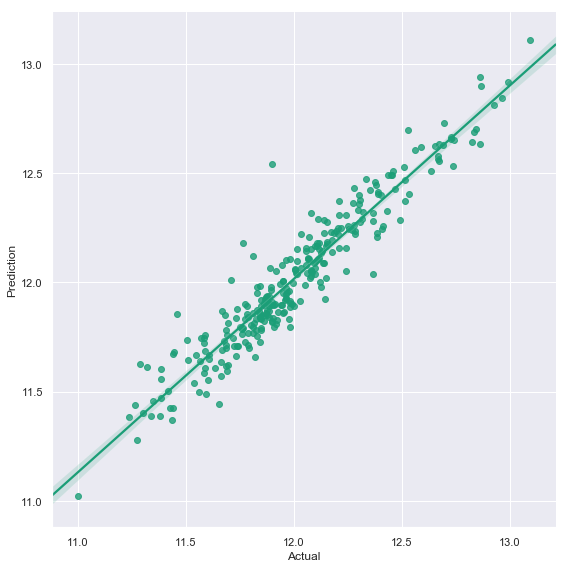

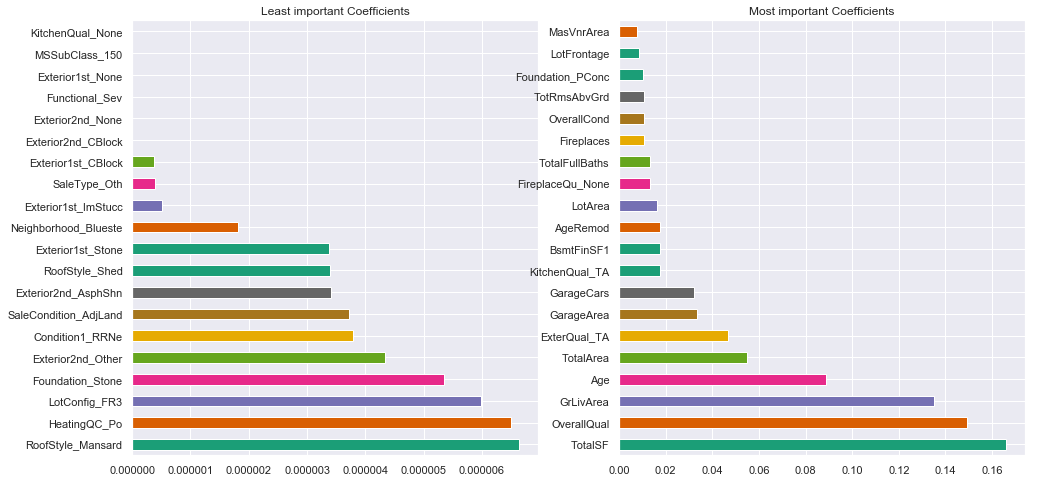

In [67]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


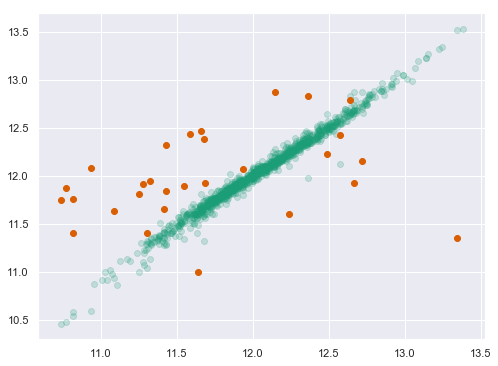

In [68]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["RF_Log2"] = outliers

In [69]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["RF_Log2"] = np.exp(pred_Y)
best_regressors["RF_Log2"] = grid_search.best_estimator_
create_submission_file(set_num, "RF_Log2", submission_data, pred_Y, log_transform=True)

# ExtraTrees with Y - Using Grid Search to override MSE with Log RMSE

In [70]:
estimator = ExtraTreesRegressor(random_state=55, oob_score=True, bootstrap=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),

    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 3.59 s, sys: 204 ms, total: 3.8 s
Wall time: 1min 34s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f2b83c8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21e31470>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(log_rmse),
          verbose=0)

Best parms :  {'max_depth': 22, 'n_estimators': 90}
Best regressor : 
 ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=22,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8544162226403692
Best RMSE Score on unseen test data: -0.12046114164438754


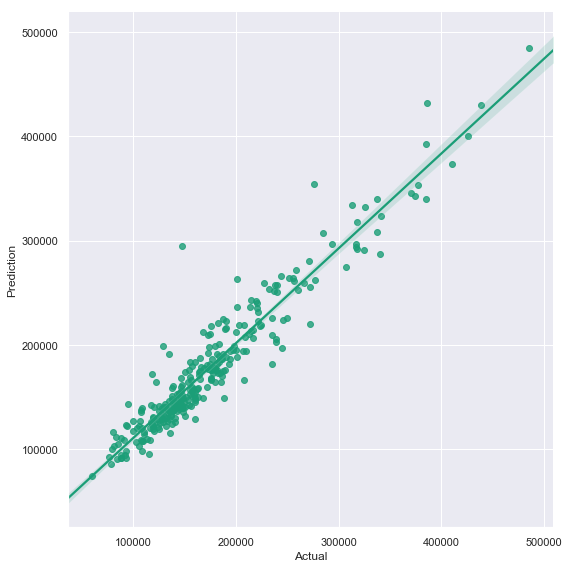

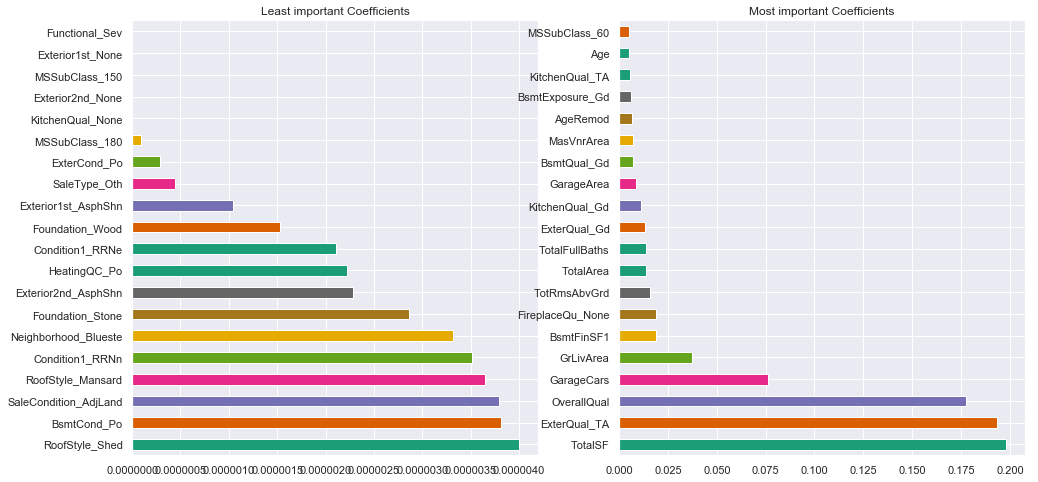

In [71]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


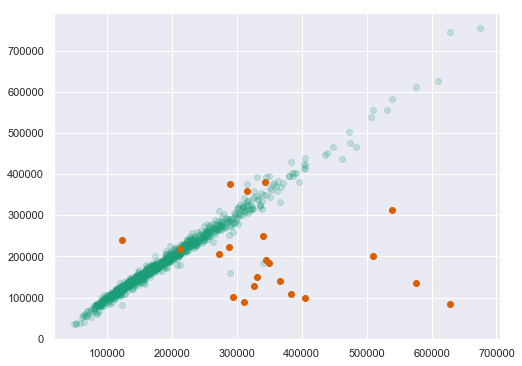

In [72]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["Extra"] = outliers

In [73]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Extra"] = pred_Y
best_regressors["Extra"] = grid_search.best_estimator_
create_submission_file(set_num, "Extra", submission_data, pred_Y)

# ExtraTrees with log(Y) - Using Grid Search to override MSE with Log RMSE

In [74]:
estimator = ExtraTreesRegressor(random_state=55, oob_score=True, bootstrap=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),

    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 3.52 s, sys: 206 ms, total: 3.73 s
Wall time: 1min 28s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21f6f320>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21e70160>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

Best parms :  {'max_depth': 37, 'n_estimators': 87}
Best regressor : 
 ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=37,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=87, n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8713217372751338
Best RMSE Score on unseen test data: -0.11079730465294382


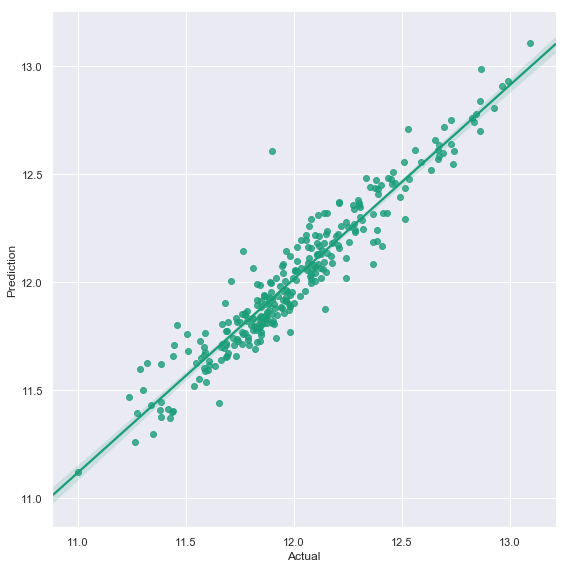

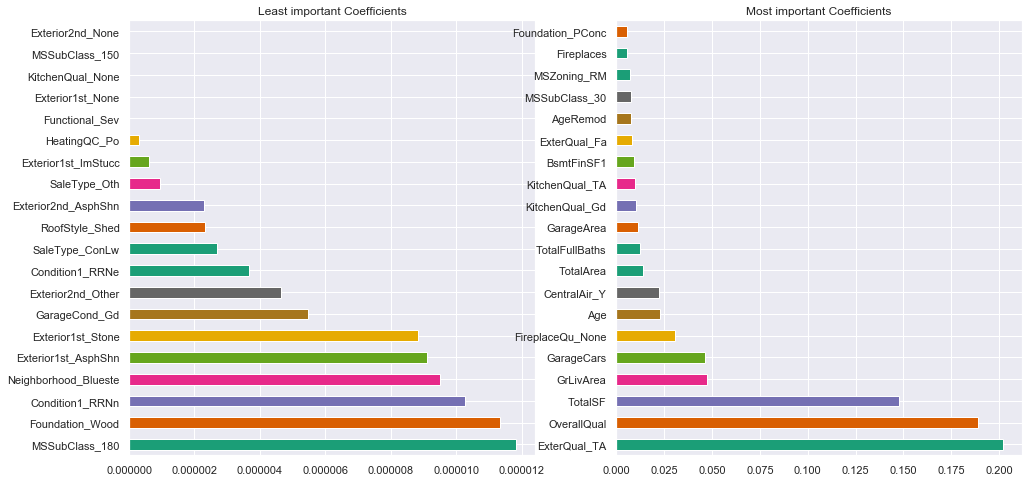

In [75]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


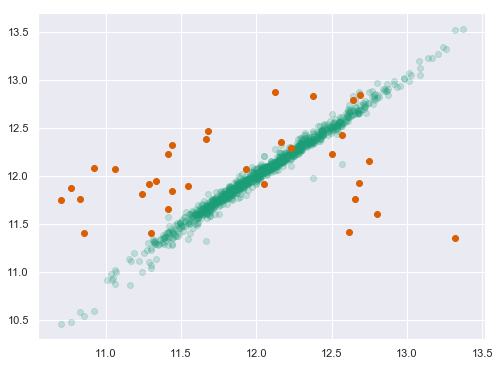

In [76]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["Extra_Log"] = outliers

In [77]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ExtraLog"] = np.exp(pred_Y)
best_regressors["ExtraLog"] = grid_search.best_estimator_
create_submission_file(set_num, "Extra_Log", submission_data, pred_Y, log_transform=True)

# GradientBoost with Y

In [78]:
estimator = GradientBoostingRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 1.97 s, sys: 45.5 ms, total: 2.01 s
Wall time: 3min 42s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21f43ba8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21f439e8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(log_rmse),
          verbose=0)

Best parms :  {'max_depth': 5, 'n_estimators': 137}
Best regressor : 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=137, n_iter_no_change=None, presort='auto',
             random_state=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Best R2 score : 0.9144493326959154
Best RMSE Score on unseen test data: -0.11197067897882428


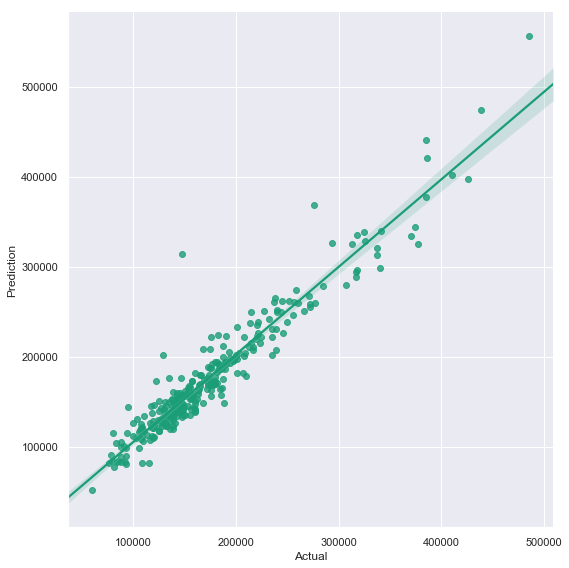

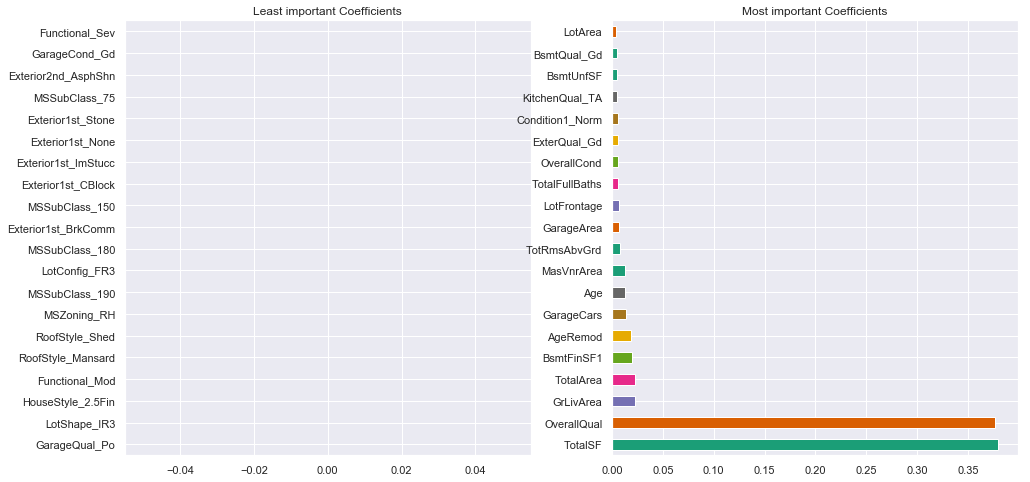

In [79]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


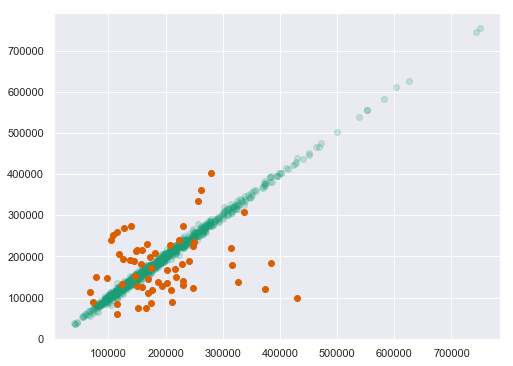

In [80]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["GB"] = outliers

In [81]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["GB"] = pred_Y
best_regressors["GB"] = grid_search.best_estimator_
create_submission_file(set_num, "GB", submission_data, pred_Y)

# GradientBoost with log(Y)

In [82]:
estimator = GradientBoostingRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 1.91 s, sys: 43.7 ms, total: 1.95 s
Wall time: 2min 1s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a22029208>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a22029b00>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

Best parms :  {'max_depth': 5, 'n_estimators': 129}
Best regressor : 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=129, n_iter_no_change=None, presort='auto',
             random_state=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Best R2 score : 0.9017259373645271
Best RMSE Score on unseen test data: -0.11280169316078927


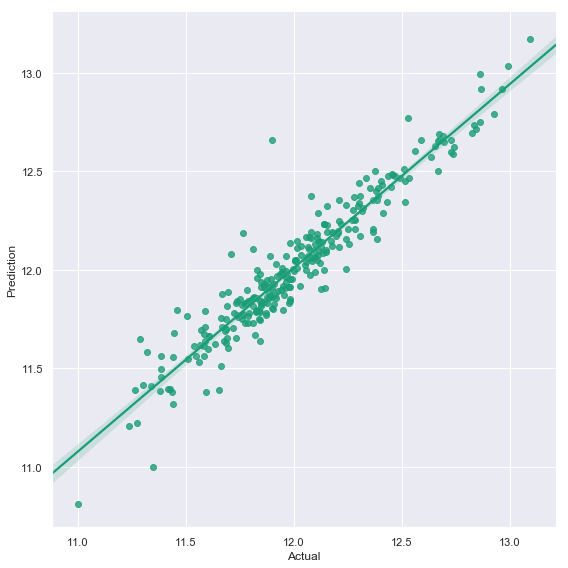

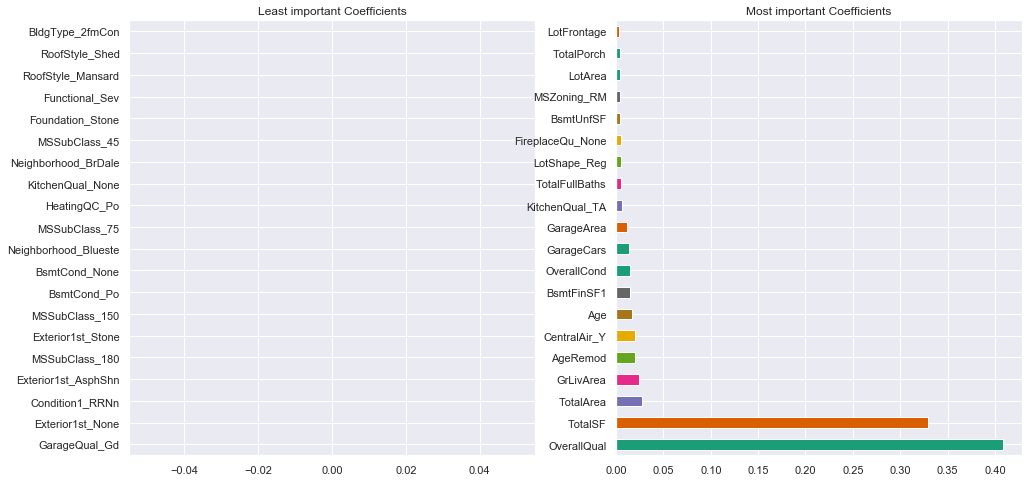

In [83]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


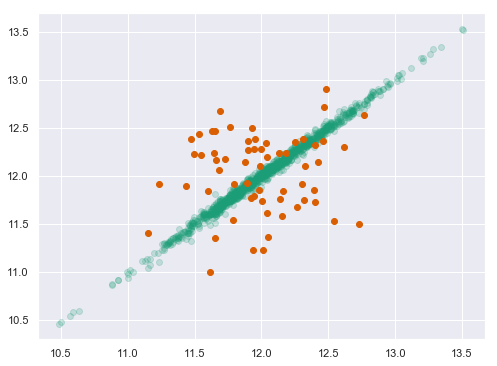

In [84]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["GB_Log"] = outliers

In [85]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["GB_Log"] = np.exp(pred_Y)
best_regressors["GB_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "GB_Log", submission_data, pred_Y, log_transform=True)

# XGBoost with Y

In [86]:
estimator = XGBRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 3.89 s, sys: 42 ms, total: 3.93 s
Wall time: 2min 7s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a203ed240>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a203ed6d8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(log_rmse),
          verbose=0)

Best parms :  {'max_depth': 7, 'n_estimators': 148}
Best regressor : 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=148,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best R2 score : 0.9134065815463236
Best RMSE Score on unseen test data: -0.112432881996893


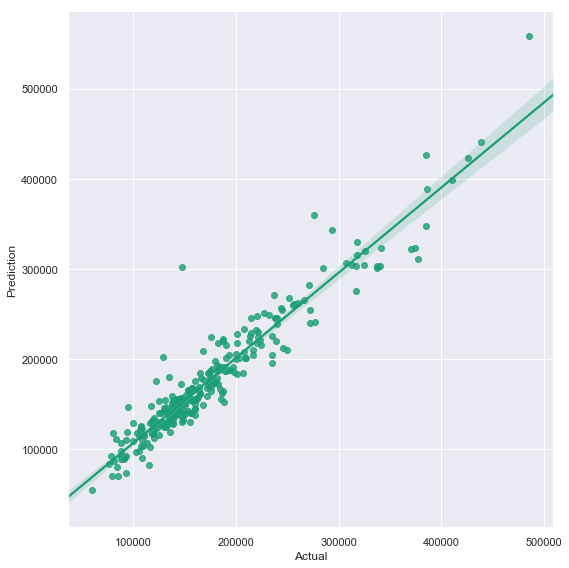

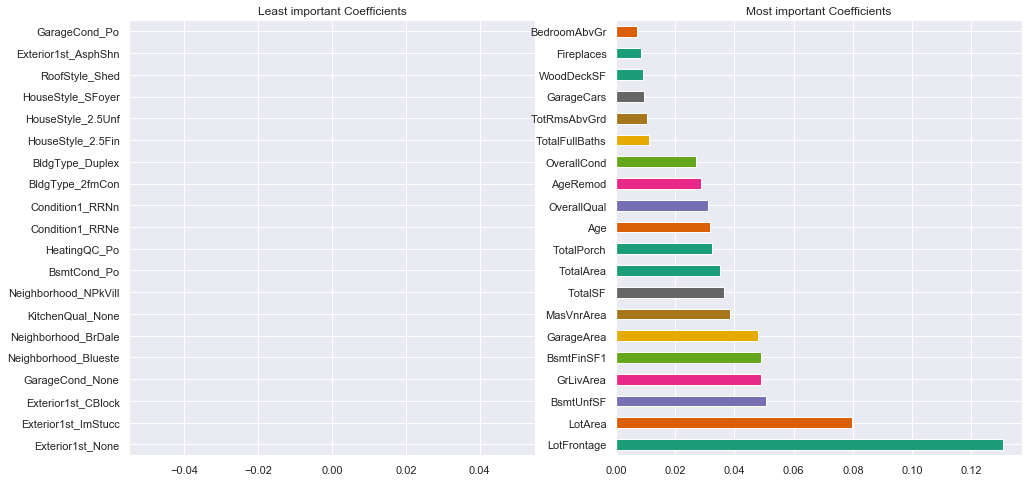

In [87]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


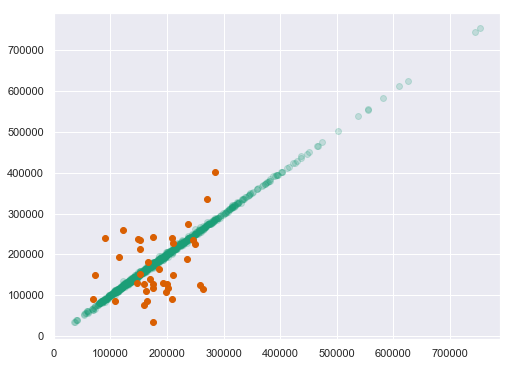

In [88]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["XGB"] = outliers

In [89]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["XGB"] = pred_Y
best_regressors["XGB"] = grid_search.best_estimator_
create_submission_file(set_num, "XGB", submission_data, pred_Y)

# XGBoost with log(Y)

In [90]:
estimator = XGBRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 2.94 s, sys: 41.3 ms, total: 2.98 s
Wall time: 1min 15s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a210b6a20>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a210b6c18>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

Best parms :  {'max_depth': 6, 'n_estimators': 127}
Best regressor : 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=127,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best R2 score : 0.9018162807749552
Best RMSE Score on unseen test data: -0.1127498319036634


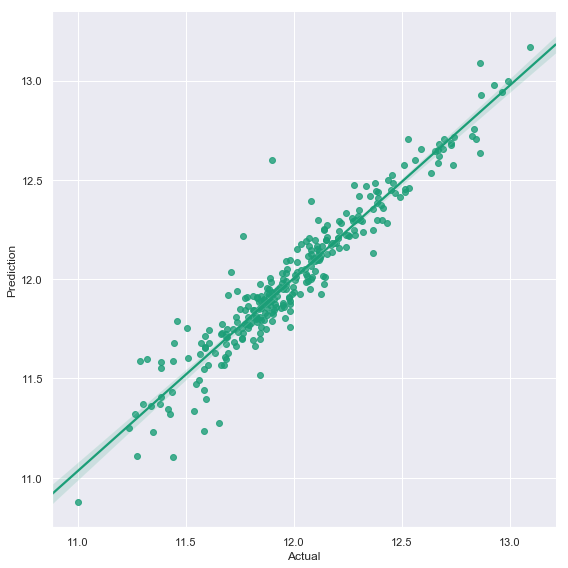

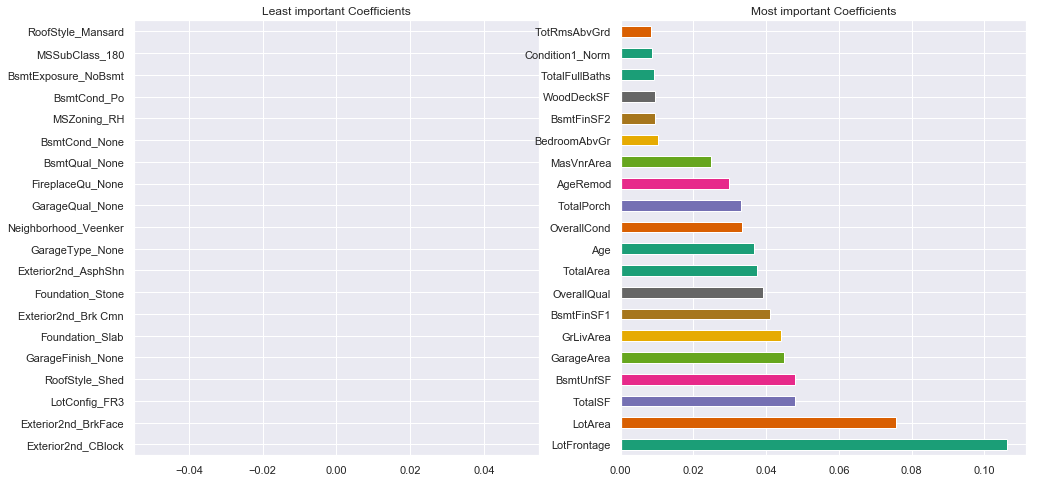

In [91]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


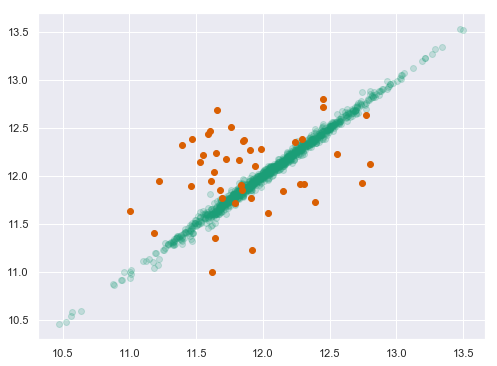

In [92]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["XGB_Log"] = outliers

In [93]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["XGB_Log"] = np.exp(pred_Y)
best_regressors["XGB_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "XGB_Log", submission_data, pred_Y, log_transform=True)

In [94]:
def store_results(set_str,results):
    df = pd.DataFrame(results)
    file = "../data/submission/" + set_str + "all_results.csv"
    df.to_csv(file)

In [95]:
store_results(set_num,results)

In [96]:
all_outliers

{'Ridge': array([   5,   77,   96,  148,  292,  314,  389,  452,  457,  459,  483,
         576,  606,  636,  701,  738,  748,  802,  977, 1069]),
 'Ridge_Log': array([   5,   18,   32,   50,   75,   92,   97,  115,  116,  240,  243,
         292,  314,  318,  389,  452,  480,  559,  589,  646,  689,  701,
         718,  738,  787,  807,  857, 1069]),
 'Lasso': array([   5,   77,   96,  148,  292,  314,  389,  452,  457,  459,  576,
         606,  636,  646,  701,  738,  748,  772,  802,  977, 1023, 1069]),
 'Lasso_Log': array([   5,   18,   26,   32,   50,   75,   92,   96,   97,  115,  116,
         117,  148,  243,  292,  314,  318,  342,  389,  446,  452,  467,
         480,  559,  646,  689,  701,  718,  738,  772,  788,  807,  837,
         846,  857,  942, 1046, 1048, 1064, 1069]),
 'ENet': array([   5,   77,   96,  292,  314,  389,  452,  457,  459,  483,  576,
         606,  636,  701,  738,  748,  802,  977, 1069]),
 'ENet_Log': array([   5,   18,   32,   50,   75,   92,   97

In [97]:
outlier_dict = {}
for key,value in all_outliers.items():
#     print((value[0]))
#     outlier_list.append(list(value))
#     np.concatenate(outlier_list,value)
    print(list(value))
    for i in list(value):
        if outlier_dict.get(i,0) == 0:
            outlier_dict[i] = 1
        else:
             outlier_dict[i]+=1

[5, 77, 96, 148, 292, 314, 389, 452, 457, 459, 483, 576, 606, 636, 701, 738, 748, 802, 977, 1069]
[5, 18, 32, 50, 75, 92, 97, 115, 116, 240, 243, 292, 314, 318, 389, 452, 480, 559, 589, 646, 689, 701, 718, 738, 787, 807, 857, 1069]
[5, 77, 96, 148, 292, 314, 389, 452, 457, 459, 576, 606, 636, 646, 701, 738, 748, 772, 802, 977, 1023, 1069]
[5, 18, 26, 32, 50, 75, 92, 96, 97, 115, 116, 117, 148, 243, 292, 314, 318, 342, 389, 446, 452, 467, 480, 559, 646, 689, 701, 718, 738, 772, 788, 807, 837, 846, 857, 942, 1046, 1048, 1064, 1069]
[5, 77, 96, 292, 314, 389, 452, 457, 459, 483, 576, 606, 636, 701, 738, 748, 802, 977, 1069]
[5, 18, 32, 50, 75, 92, 97, 115, 116, 240, 243, 292, 314, 318, 389, 452, 480, 559, 589, 646, 689, 701, 718, 738, 787, 807, 857, 1048, 1069]
[5, 18, 32, 50, 75, 92, 97, 115, 116, 240, 243, 314, 318, 389, 452, 480, 559, 589, 646, 689, 701, 718, 738, 787, 807, 857, 1069]
[5, 77, 96, 148, 209, 292, 314, 389, 452, 457, 459, 576, 606, 636, 701, 738, 748, 772, 802, 977, 1069]

In [98]:
outlier_dict

{5: 14,
 77: 7,
 96: 8,
 148: 6,
 292: 10,
 314: 14,
 389: 14,
 452: 9,
 457: 7,
 459: 5,
 483: 2,
 576: 5,
 606: 5,
 636: 7,
 701: 12,
 738: 18,
 748: 4,
 802: 9,
 977: 9,
 1069: 15,
 18: 7,
 32: 10,
 50: 7,
 75: 11,
 92: 5,
 97: 9,
 115: 11,
 116: 7,
 240: 7,
 243: 5,
 318: 8,
 480: 11,
 559: 6,
 589: 6,
 646: 7,
 689: 7,
 718: 6,
 787: 6,
 807: 7,
 857: 10,
 772: 5,
 1023: 1,
 26: 1,
 117: 1,
 342: 1,
 446: 3,
 467: 1,
 788: 4,
 837: 1,
 846: 1,
 942: 1,
 1046: 3,
 1048: 5,
 1064: 5,
 209: 1,
 290: 2,
 458: 2,
 609: 5,
 979: 3,
 1144: 1,
 189: 1,
 276: 5,
 453: 1,
 663: 3,
 1073: 1,
 225: 1,
 456: 2,
 644: 1,
 816: 3,
 938: 4,
 1041: 3,
 1049: 2,
 1101: 4,
 4: 1,
 439: 2,
 478: 2,
 753: 2,
 761: 2,
 16: 1,
 17: 1,
 95: 2,
 299: 1,
 448: 1,
 743: 1,
 10: 2,
 36: 3,
 44: 1,
 67: 1,
 149: 2,
 195: 1,
 200: 2,
 296: 1,
 316: 2,
 332: 3,
 372: 1,
 375: 2,
 385: 4,
 392: 2,
 404: 4,
 415: 2,
 416: 3,
 434: 2,
 442: 3,
 455: 3,
 493: 1,
 572: 1,
 575: 1,
 585: 1,
 598: 4,
 608: 3,
 615: 2,

In [99]:
[print(key, value) for key,value in outlier_dict.items() if value>8]

5 14
292 10
314 14
389 14
452 9
701 12
738 18
802 9
977 9
1069 15
32 10
75 11
97 9
115 11
480 11
857 10


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [119]:
from sklearn.neural_network import MLPRegressor
rgsr = MLPRegressor(max_iter=20000, learning_rate='adaptive', learning_rate_init=0.01,
                   random_state=55, hidden_layer_sizes=(50,))
%time rgsr.fit(train_X, train_Y)
print(rgsr.score(train_X, train_Y))
print(rgsr.score(test_X, test_Y))
print(log_rmse(rgsr.predict(test_X),test_Y))
print(rgsr.n_iter_)

CPU times: user 30.6 s, sys: 151 ms, total: 30.7 s
Wall time: 15.6 s
0.8927830003419321
0.8727763848928456
-0.15925639298126415
3609


In [124]:
from sklearn.neural_network import MLPRegressor
rgsr = MLPRegressor(max_iter=10000,  learning_rate_init=0.01,
                   random_state=55, hidden_layer_sizes=(55,))
%time rgsr.fit(train_X2, train_Y2)
print(rgsr.score(train_X2, train_Y2))
print(rgsr.score(test_X2, test_Y2))
print(rmse(rgsr.predict(test_X2),test_Y2))
print(rgsr.n_iter_)

CPU times: user 1.31 s, sys: 4.84 ms, total: 1.31 s
Wall time: 661 ms
0.7652209782008357
0.3193800408837719
-0.29685782675672356
158
